## Detect the mitosis locations & Numbers for WSI/ROI/Tile

### Introdcution
This project is developed for the Tumor Proliferation Assessment Challenge 2016 (TUPAC16). A large scale CNN-based framework is proposed and implemented to automatically detect mitosis locations and predict the tumor proliferation score, which is an important biomarker indicative of breast cancer patients' prognosis. The density of mitosis is closely related to tumor growth, so the most common method for predicting the tumor proliferation score is to count the number of mitoses in hematoxylin & eosin (H&E) stained histological slides. 

Based on these knowledge, we did not train an end-to-end CNN model (WSI -> tumor proliferation score). Instead, we first utilize Tensorflow and Keras to train a CNN model to detect mitosis locations from medical images, and then train a SVM model on these detected mitosis location data to predict the tumor proliferation score. 

This notebook focuses on how to use the well-trained model to detect the mitosis locations and predict the tumor proliferation score.

### Workflow

<img src="inference_workflow.jpg">

In particular, the inference workflow is as following:
    1. generate the overlapped ROIs for each WSI
    2. generate the overlapped tiles for each ROI
    3. load the model (VGG/ResNet) to predict the mitosis locations for each ROI
    4. cluster/smooth the prediction results to avoid the duplicated prediction
    5. visualize the prediction results
    6. compute the F1 score to evaluate the prediction result
    7. archive the prediction results 
    8. Hyper parameter search for SVM model to predict the tumor proliferation score
    

### Capabilities
Note that the above pipelin is extremely computing-intensive, so Spark and GPU are leveraged to accelerate the prediction process:
    1. data parallel: according to the available computing resources in the spark cluster,  split the input imagess to several partions with same number of images to achieve work load balance. 
    2. schedule the GPU resources for each parition
    3. support both CPU and GPU modes
    

In [1]:
from deephistopath.inference import check_subsetting, predict_mitoses
from time import gmtime, strftime
import shutil

### 1. Prepare the python libraries for each Spark worker
Ship a fresh copy of the `deephistopath` package to the Spark workers. Note: The zip must include the `deephistopath` directory itself, as well as all files within it for `addPyFile` to work correctly. This is equivalent to `zip -r deephistopath.zip deephistopath`.

In [2]:
dirname = "deephistopath"
zipname = dirname + ".zip"
shutil.make_archive(dirname, 'zip', dirname + "/..", dirname)
sc.addPyFile(zipname)
sc.addPyFile("train_mitoses.py")
sc.addPyFile("preprocess_mitoses.py")
sc.addPyFile("resnet50.py")

### 2. Configure the parameters for the mitosis location detection
These parameters determine how to use the model to detect the mitosis locations:

* `model_name`: model name for the input model, e.g. vgg, resnet.
* `skipROI`: True to skip the ROI layer; False to keep the ROI layer. For the WSI, it needs to be set True to generate ROIs for each SVS file, and then generate tiles for each ROI; For small input images, it could be set False to directly generate tiles from the original input images. 
* `marginalization`: boolean value to indicate if applying the marginalization techniques into the prediction process. If True, each tile will be augmented to a bunch of augmented tiles (the number of augmented tiles will be same with the batch size), and then average the prediction scores for each augmented tiles as the final prediction score. This method will reduce the FP cased to improve the F1 score, but it is very time-consuming. (Credits to Mike Dusenberry)
* `batch_size`: the batch size for prediction.
* `tile_overlap`: the overlap between neighbor tiles.
* `suffix`: image suffix. It will be used to filter the input data.
* `threshold`: the probability threshold used in the activation layer for the prediction. If setting it as 0, it will save all the prediction results into csv files, which can be used later to investigate the influence of different probability thresholds on the F1 score.
* `dir`: the input data directory path.
* `model_file`: the file path for the input model file.
* `node_nume`: the number of worker nodes in the Spark cluster.
* `gpu_per_node`: the number of available GPUs on each worker node. We assume that each node will have the same number of GPUs.
* `partition_num`: the number of data partitions.
* `ROI_size`: the size of ROI.
* `ROI_overlap`: the overlap between neighbor ROIs.
* `ROI_channel`: the number of channels in the ROI.
* `tile_size`: the size of tile.
* `tile_channel`: the number of channels for each tile.
* `isGPU`: boolean value to indicate if running the prediction jobs on the GPUs.
* `isDebug`: boolean value to indicate if outputing the debug information.
* `save_mitosis_locations`: boolean value to indicate if saving the detected mitosis locations in the csv files.
* `save_mask`: boolean value to indicate if saving the detected mitosis locations as masks in images, and it will also save all locations in another tiff images with tumor data. The rule for naming the output file path is to replace 'data' in the input file path by 'result'. For example, if the input path is '/8tb/deep_histopath/pred/data/vgg/val', the output path will be '/8tb/deep_histopath/pred/result/vgg/val'.

In [13]:
model_name = 'vgg' #'resnet'
skipROI = True
marginalization = False
batch_size = 128
tile_overlap = 48
suffix = '*.tif'
threshold = 0.5

if model_name == 'vgg':
    #model_file = '/8tb/deep_histopath/pred/model/0.67899_f1_3.5448_loss_3_epoch_model.hdf5'
    model_file = '/8tb/deep_histopath/pred/model/0.74172_f1_1.7319_loss_8_epoch_model.hdf5'
    dir = '/8tb/deep_histopath/pred/data/vgg/val'
elif model_name == 'resnet':
    model_file = '/8tb/deep_histopath/pred/model/0.72938_f1_0.067459_loss_7_epoch_model.hdf5'
    dir = '/8tb/deep_histopath/pred/data/resnet/val'

node_num = 1
gpu_per_node = 4
partition_num = gpu_per_node * node_num
ROI_size = 6000
ROI_overlap = 60
ROI_channel = 3
tile_size = 64
tile_channel = 3
isGPU = True
isDebug = True
save_mitosis_locations=True
save_mask = True

predict_result_rdd = predict_mitoses(sc, model_path=model_file, model_name = model_name, input_dir=dir, 
                                     file_suffix=suffix, partition_num=partition_num,
                                     ROI_size=ROI_size, ROI_overlap=ROI_overlap, ROI_channel=ROI_channel,
                                     skipROI=skipROI,
                                     marginalization=marginalization,
                                     tile_size=tile_size, tile_overlap=tile_overlap, tile_channel=tile_channel,
                                     threshold=threshold, isGPU=isGPU, 
                                     save_mitosis_locations=save_mitosis_locations,
                                     save_mask=save_mask,
                                     batch_size=batch_size, isDebug=isDebug)
predict_result_rdd.cache()

Counter({'rr-ram3.softlayer.com': 0})
[(0, 'rr-ram3.softlayer.com'), (1, 'rr-ram3.softlayer.com'), (2, 'rr-ram3.softlayer.com'), (3, 'rr-ram3.softlayer.com')]
{0: 3, 1: 2, 2: 1, 3: 0}


PythonRDD[32] at RDD at PythonRDD.scala:48

### 3. Run the prediction job
Activate the run of prediction job, and the prediction results will be cached in the memory as RDD. Each element in the RDD will be like a tuple of (slide_id, ROI_id, mitoses_num, a list of mitosis locations with prediction scores), e.g. ('_8tb_deep_histopath_pred_data_vgg_val_11_12_tif', 'ROI_0_0', 2, [(432, 576, 0.7314478158950806), (1344, 1920, 0.6996474266052246)])

In [14]:
start_time = strftime("%Y-%m-%d %H:%M:%S",gmtime())
print(start_time)
result = predict_result_rdd.count()
print(f"Number of input images: {result}")
end_time = strftime("%Y-%m-%d %H:%M:%S",gmtime())
print(end_time)

2017-12-19 18:35:53
Number of input images: 174
2017-12-19 19:01:25


### 4. Save the prediction results into CSV
Save the prediction data in `predict_result_rdd` to csv files. Since `predict_result_rdd` aggregate the detected mitoses by the slide id, each element in `predict_result_rdd` will contain multiple mitosis locations. The following code will flat each element in `predict_result_rdd` into multiple rows, each of which will only contain a single mitosis location.

In [15]:
from pyspark.sql import SparkSession
import re

def flat_result_2_row(predictions, reg_exp="\d+_\d+"):
  assert predictions is not None
  result = []
  slide_id, ROI, mitosis_num, mitosis_location_scores = predictions
  for r, c, score in mitosis_location_scores:
    slide_id = re.findall(reg_exp, slide_id)[0]
    result.append((slide_id, ROI, mitosis_num, r, c, score))
  return result

csv_path = "/8tb/deep_histopath/pred/result/vgg/val_test.csv"
spark = (SparkSession.builder.appName("convert_predictions_to_csv").getOrCreate())


pred_rows = predict_result_rdd.filter(lambda t: t is not None).flatMap(lambda t: flat_result_2_row(t)).cache()

df = spark.createDataFrame(pred_rows, ['slide_id', 'ROI_id', 'mitosis_num_per_ROI', 'row_num', 'col_num', 'score'])

dir = os.path.dirname(csv_path)
os.makedirs(dir, exist_ok=True)
df.toPandas().to_csv(csv_path, header=True, index=False)
df.show()

+--------+-------+-------------------+-------+-------+------------------+
|slide_id| ROI_id|mitosis_num_per_ROI|row_num|col_num|             score|
+--------+-------+-------------------+-------+-------+------------------+
|   35_01|ROI_0_0|                  6|   1504|   4080|0.6960358023643494|
|   35_01|ROI_0_0|                  6|   1504|   4096|0.6770667433738708|
|   35_01|ROI_0_0|                  6|   1520|   4080|0.8123036026954651|
|   35_01|ROI_0_0|                  6|   1520|   4096|0.8053736686706543|
|   35_01|ROI_0_0|                  6|   2032|    464| 0.718071699142456|
|   35_01|ROI_0_0|                  6|   2032|    480|0.6161556243896484|
|   11_13|ROI_0_0|                  5|    896|    672|0.5777602791786194|
|   11_13|ROI_0_0|                  5|    912|    672|0.5610048770904541|
|   11_13|ROI_0_0|                  5|    944|   1920| 0.592004120349884|
|   11_13|ROI_0_0|                  5|    944|   1936|0.5845569372177124|
|   11_13|ROI_0_0|                  5|

## 5. Cluster the prediction result

The overlapped prediction will lead to some duplicated predictions. In order to remove the duplication, the DBScan algorithm is utlized to cluster the original prediction result.

In [16]:
from deephistopath.detection import cluster_prediction_result

cluster_prediction_result(pred_dir="/8tb/deep_histopath/pred/result/vgg/val/", 
                          eps=64-tile_overlap, min_samples=1, hasHeader=True, 
                          isWeightedAvg=False, prob_threshold=0.5)

## 6. Visualize the mitosis locations
It will visualize the mitosis locations on the tumor images. By inputting different mitosis data, it could visualize the ground truth data and prediction data with different color, shape, and size. The visualization job can be run in parallel using Spark. For the predicted mitosis, the mark size indicates the preodiction probability.

* `im_dir`: the directory path for the input tumor images.
* `partition_num`: the number of partitions for Spark.
* `im_suffix`: the suffix for the input images.
* `mitosis_location_csv_suffix`: the suffix for the input mitosis location files.
* `mitosis_location_file_dir`: the directory path for the input mitosis location files. 
* `mark_color`: RGBa for the mark color.
* `mark_shape`: The mark shape, e.g. Shape.CIRCLE, Shape.SQUARE, Shape.CROSS
* `hasHeader`: boolean value to indicate if the input mitosis location csv files have the header.
* `hasProb`: boolean value to indicate if the input mitosis location csv files have the prediction probability column. If True, the mark size in the visualization result will be equalt to default_size * pred_probability. If false, the mark size will be the default size. 

In [17]:
from deephistopath.evaluation import add_ground_truth_mark
from deephistopath.visualization import Shape
from pathlib import Path
import re

im_dir = "/8tb/deep_histopath/pred/result/vgg/val"
partition_num = 4
im_suffix = "*mark.tif"
mitosis_location_csv_suffix = "*.csv"


# Add the marks for the ground truth. Note that the ground truth file does not have file schema
mitosis_location_file_dir = "/8tb/deep_histopath/pred/data/val_ground_truth/"
mark_color=(255, 255, 0, 200)
shape = Shape.CIRCLE
hasHeader = False
add_ground_truth_mark(sc, partition_num, im_dir, im_suffix, mitosis_location_file_dir, mitosis_location_csv_suffix, 
                      shape=shape, mark_color=mark_color, hasHeader=hasHeader, hasProb=False)


# Add the marks for the original prediction results
mitosis_location_file_dir = "/8tb/deep_histopath/pred/result/vgg/val"
mark_color=(0, 255, 0, 200)
shape = Shape.SQUARE
hasHeader = True
add_ground_truth_mark(sc, partition_num, im_dir, im_suffix, mitosis_location_file_dir, mitosis_location_csv_suffix, 
                      shape=shape, mark_color=mark_color, hasHeader=hasHeader, hasProb=True)

# Add the marks for the clustered prediction results
mitosis_location_file_dir = "/8tb/deep_histopath/pred/result/vgg/val_clustered"
mark_color=(255, 0, 0, 200)
shape = Shape.CROSS
hasHeader = True
add_ground_truth_mark(sc, partition_num, im_dir, im_suffix, mitosis_location_file_dir, mitosis_location_csv_suffix, 
                      shape=shape, mark_color=mark_color, hasHeader=hasHeader, hasProb=True)

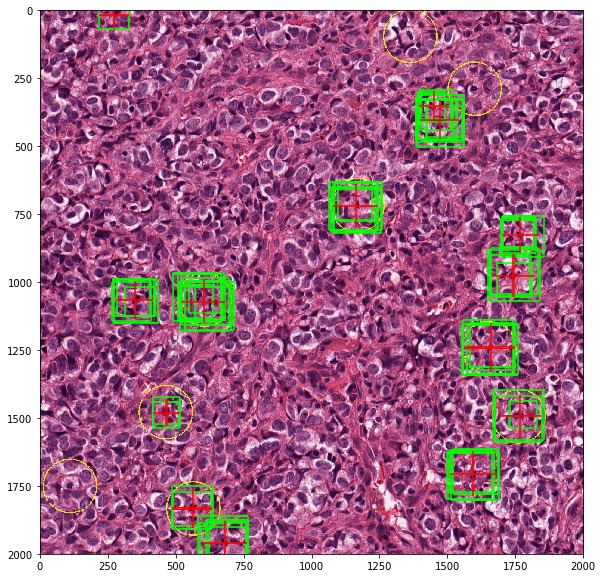

In [18]:
# display one of the marked mitosis image
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

img_path = '/8tb/deep_histopath/pred/result/vgg/val/21/35_mark.tif'
img = Image.open(img_path)
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(img)
plt.show()


## 7. Compute F1 score
Evaluate the prediction results by computing the F1 score. The details about how to compute F1 score could be found at [http://amida13.isi.uu.nl/?q=node/4](http://amida13.isi.uu.nl/?q=node/4). In the function `evaluate_global_f1`, a new probability threshold can be input to further filter the predictions. It provides a way to investigate the influence of different probability thresholds on F1 score.

* `pred_dir`: the directory for the prediction files in csv format. These csv files should have file header.
* `ground_true_dir`: the directory forthe ground truth data. These csv files should not have file header.
* `dist_threshold`: the Eucledian distance threshold (circle radius) to judge if the prediction is FP.
* `prob_threshold`: the probability threshold to judge if the prediction is a mitosis. Note that, we also suppot inputting the probability threshold at the step 2 and 5.

In [10]:
from deephistopath.evaluation import evaluate_global_f1

pred_dir = "/8tb/deep_histopath/pred/result/vgg/val_clustered"
ground_true_dir = "/8tb/deep_histopath/pred/data/val_ground_truth/"
dist_threshold = 30  
prob_threshold = 0.7
f1, precision, recall, over_detected, non_detected, FP, TP, FN = evaluate_global_f1(pred_dir, 
                                                                                    ground_true_dir, 
                                                                                    dist_threshold, 
                                                                                    prob_threshold)

print(f"F1: {f1}; Precision: {precision}; Recall: {recall}; FP: {len(FP)}; TP: {len(TP)}; FN: {len(FN)}")


Point (1558 , 1633) has multiple points in the circle
Point (1506 , 1653) has multiple points in the circle
F1: 0.5664893617021276; Precision: 0.5246305418719212; Recall: 0.615606936416185; FP: 193; TP: 213; FN: 133


## 8. Export TP, FP, FN to CSV File
TP, FP, FN can be outputted into a single big csv file. They can also be stored seperately into several folders. 

In [10]:
from deephistopath.evaluation import export_F1_inputs_TP_FP_FN, export_single_F1_input
export_F1_inputs_TP_FP_FN('/8tb/deep_histopath/pred/result/vgg/val-test-FP-TP_FN-label.csv', FP, TP, FN)
export_single_F1_input('/8tb/deep_histopath/pred/result/vgg/val_test-FP-test/', FP, "FP")
export_single_F1_input('/8tb/deep_histopath/pred/result/vgg/val_test-FN-test/', FN, "FN")

In [11]:
import pandas as pd
df = pd.read_csv('/8tb/deep_histopath/pred/result/vgg/val-test-FP-TP_FN-label.csv')
fp_df = df[df['label'] == 'FP']
print("False Positive Cases: \n")
print(fp_df)

False Positive Cases: 

   file_id   row   col      prob label
0    21/41   300   420  0.873038    FP
1    15/10   360     0  0.967760    FP
2    15/31   720   420  0.813767    FP
3    21/18  1560  1020  0.936278    FP
4    15/08   420   660  0.723447    FP
5    15/17  1200  1620  0.763389    FP
6    21/15     0   720  0.734712    FP
7    22/04  1800  1320  0.793162    FP
8    21/35   960  1740  0.798648    FP
9    35/01  1500  4080  0.719924    FP
10   21/34     0   420  0.990115    FP
11   54/01  4680  1320  0.905703    FP
12   21/21  1500   480  0.933006    FP
13   21/12   600   780  0.776652    FP
14   21/12  1680  1620  0.793067    FP
15   21/19  1560   600  0.760359    FP
16   21/19  1680  1920  0.954511    FP
17   15/38     0   720  0.732786    FP
18   15/40     0   660  0.701375    FP
19   15/40  1440  1260  0.702283    FP
20   22/07  1200   240  0.818175    FP
21   21/07   840  1440  0.865008    FP
22   21/26  1680   180  0.731514    FP
23   15/30   780  1440  0.970568    FP
2

## 9. Tumor Proliferation Score Prediction
It will load the csv files of the mitosis locations and the ground truth data. Then prepare the input features for the SVM model, and join the training data and groud truth data together. The input hyper parameters for the SVM model will be parallelized and the SVM models will be trained in parallel. The model evaluation results with its parameters will be collected as a table.

In [12]:
import scipy
from scipy.stats import randint, uniform
from deephistopath.predict import search_hyper_parameter

ground_truth_file_path = "/8tb/deep_histopath/data/training_ground_truth.csv"

pred_file_paths = ["/8tb/deep_histopath/pred/result/mitosis_pred_examples/mitosis_prediction_result_svs_000.csv",
                   "/8tb/deep_histopath/pred/result/mitosis_pred_examples/mitosis_prediction_result_svs_100.csv",
                   "/8tb/deep_histopath/pred/result/mitosis_pred_examples/mitosis_prediction_result_svs_200.csv",
                   "/8tb/deep_histopath/pred/result/mitosis_pred_examples/mitosis_prediction_result_svs_300.csv",
                   "/8tb/deep_histopath/pred/result/mitosis_pred_examples/mitosis_prediction_result_svs_400.csv"]
cv = 10
score = 'kappa'
test_data_size = 0.2
seed = 0
y_name = 'mitosis_score'
parameter_search_mode = 'random' #grid
n_iter = 100 # 2000

FEATURE_COLUMNS = ['sum', 'std', 'avg',
                   'sum_top10', 'std_top10', 'avg_top10',
                   'sum_top30_70', 'std_top30_70', 'avg_top30_70']

selected_feature_names = FEATURE_COLUMNS[0:len(FEATURE_COLUMNS)]

tuned_parameters = [{'C': scipy.stats.expon(loc=1, scale=10),
                        'gamma': scipy.stats.expon(loc=1, scale=10),
                        'kernel': ['rbf'],
                        'class_weight': ['balanced', None]},
                        {'C': scipy.stats.expon(loc=10, scale=10),
                         'gamma': scipy.stats.expon(loc=0.1, scale=10),
                         'kernel': ['rbf'],
                         'class_weight': ['balanced', None]},
                        {'C': scipy.stats.expon(loc=0.1, scale=10),
                         'gamma': scipy.stats.expon(loc=0.01, scale=10),
                         'kernel': ['rbf'],
                         'class_weight': ['balanced', None]},
                        {'C': uniform(loc=0.001, scale=0.009),
                         'gamma': uniform(loc=0.1, scale=0.9),
                         'kernel': ['rbf'],
                         'class_weight': ['balanced', None]},
                        {'C': uniform(loc=0.001, scale=0.009),
                         'gamma': uniform(loc=0.01, scale=0.09),
                         'kernel': ['rbf'],
                         'class_weight': ['balanced', None]}]

model_evaluation_results = search_hyper_parameter(sparkContext=sc,
                                                  parameters=tuned_parameters,
                                                  parameter_search_mode=parameter_search_mode,
                                                  score=score,
                                                  x_files=pred_file_paths,
                                                  y_file=ground_truth_file_path,
                                                  selected_feature_names=selected_feature_names,
                                                  y_name=y_name,
                                                  test_size=test_data_size,
                                                  cv=cv, seed=seed,
                                                  n_iter=n_iter)



In [17]:
import pandas as pd
df = pd.DataFrame(model_evaluation_results, columns=['kappa-score', 'std', 'parameters'])
with pd.option_context("display.max_rows", len(model_evaluation_results), 
                       "display.max_columns", 3,
                       "expand_frame_repr", False):
    print(df)

   kappa-score       std                                         parameters
0    -0.009129 -0.042146  {'C': 3.76417040872, 'class_weight': 'balanced...
1     0.001665  0.003717  {'C': 10.9332933171, 'class_weight': None, 'ga...
2     0.047921  0.019694  {'C': 0.277450587143, 'class_weight': 'balance...
3     0.027322  0.000000  {'C': 0.00553713637792, 'class_weight': 'balan...
4     0.039360  0.000000  {'C': 0.00431410449255, 'class_weight': 'balan...
